## Tanzania Water Wells Classification Modelling

### Importing relevant dependancies

In [1]:
# importations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix,\
    classification_report

from functions import drop_artefacts_and_nulls, calculate_age
from functions import cross_val_evaluate
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

#read training data
train_set = pd.read_csv('Data/labelled_train_set.csv')

#train set
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,needs_repair
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Preprocessing

In [2]:
#list column names for categorical and numerical
cat_cols = drop_artefacts_and_nulls(train_set).select_dtypes(include='object').columns
num_cols = drop_artefacts_and_nulls(train_set).select_dtypes(include='number').columns
print('Categorical:\n', cat_cols)
print('Numerical:\n', num_cols)

Categorical:
 Index(['date_recorded', 'installer', 'basin', 'subvillage', 'lga', 'ward',
       'scheme_management', 'permit', 'extraction_type_class',
       'management_group', 'quality_group', 'quantity', 'source',
       'waterpoint_type', 'status_group'],
      dtype='object')
Numerical:
 Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year'],
      dtype='object')


In [3]:
#column groups
cat_cols = ['installer', 'basin', 'subvillage', 'lga', 'ward', 'scheme_management',
       'permit', 'extraction_type_class', 'management_group', 'quality_group',
       'quantity', 'source', 'waterpoint_type']

num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'age']

**Transformers**

In [4]:
#function transformer for dropping irrelevant features and nulls
feature_selector = FunctionTransformer(drop_artefacts_and_nulls)

#feature engineering to calculate age
age_transformer = FunctionTransformer(calculate_age)

#column transformer to transform target
target_transformer = ColumnTransformer(transformers=[
    ('le', LabelEncoder(), ['status_group']),
])

#categorical transformer
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

#numerical transformer
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


#Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    # ('target_trans', target_transformer)
])


**Cleaning Pipelines**

In [5]:
# cleaning pipeline
feature_cleaner = Pipeline(steps=[
    ('feat_select', feature_selector),
    ('age_trans', age_transformer)
])


>Cleaning the the whole training set before spliting

In [6]:
clean_train_set = feature_cleaner.fit_transform(train_set)
clean_train_set.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,subvillage,region_code,district_code,lga,...,permit,construction_year,extraction_type_class,management_group,quality_group,quantity,source,waterpoint_type,status_group,age
0,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,Mnyusi B,11,5,Ludewa,...,False,1999,gravity,user-group,good,enough,spring,communal standpipe,functional,12
1,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Nyamara,20,2,Serengeti,...,True,2010,gravity,user-group,good,insufficient,rainwater harvesting,communal standpipe,functional,3
2,25.0,686,World vision,37.460664,-3.821329,Pangani,Majengo,21,4,Simanjiro,...,True,2009,gravity,user-group,good,enough,dam,communal standpipe multiple,functional,4
3,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,90,63,Nanyumbu,...,True,1986,submersible,user-group,good,dry,machine dbh,communal standpipe multiple,needs_repair,27
5,20.0,0,DWE,39.172796,-4.765587,Pangani,Moa/Mwereme,4,8,Mkinga,...,True,2009,submersible,user-group,salty,enough,other,communal standpipe multiple,functional,2


In [7]:
#X and Y
X = clean_train_set.drop('status_group', axis=1)
y = clean_train_set['status_group']

In [8]:
y.value_counts()

functional      27864
needs_repair    23092
Name: status_group, dtype: int64

**Actual Preprocessing Pipeline**

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)
X_train.head()

,amount_tsh,gps_height,installer,longitude,latitude,basin,subvillage,region_code,district_code,lga,...,scheme_management,permit,construction_year,extraction_type_class,management_group,quality_group,quantity,source,waterpoint_type,age
46491,0.0,1146,DWE,33.212282,-2.129424,Lake Victoria,Buhoro,20,4,Bunda,...,WUG,False,1999,other,user-group,salty,dry,shallow well,other,14
29041,500.0,1518,Shipo,35.061051,-8.864005,Rufiji,Ilengititu,11,4,Njombe,...,VWC,False,2008,rope pump,user-group,good,enough,hand dtw,hand pump,3
6098,0.0,103,District Council,39.450761,-10.033486,Ruvuma / Southern Coast,Milola,80,23,Lindi Rural,...,VWC,False,2004,gravity,user-group,good,enough,river,communal standpipe,9
44610,0.0,0,DWE,33.105349,-2.420292,Lake Victoria,Kiloleli,19,2,Magu,...,VWC,True,0,handpump,user-group,good,insufficient,shallow well,hand pump,2011
23657,0.0,1386,DWE,34.582432,-8.900268,Rufiji,Lulanga,11,4,Njombe,...,WUA,True,1978,gravity,user-group,good,enough,river,communal standpipe,33


In [10]:
#fit cleaned data into pipeline
# clean_X_train = feature_cleaner.fit_transform(X_train).drop('status_group', axis=1)
# clean_X_train.head()


In [11]:
# reassign column groups
cat_cols = clean_train_set.select_dtypes(include='object').columns
num_cols = clean_train_set.select_dtypes(include='number').columns
print('Categorical:\n', cat_cols)
print('Numerical:\n', num_cols)

Categorical:
 Index(['installer', 'basin', 'subvillage', 'lga', 'ward', 'scheme_management',
       'permit', 'extraction_type_class', 'management_group', 'quality_group',
       'quantity', 'source', 'waterpoint_type', 'status_group'],
      dtype='object')
Numerical:
 Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'age'],
      dtype='object')


In [12]:
#compare target and X lengt
print('Target length:',len(y_train))
print('Predictor length:', len(X_train))

Target length: 38217
Predictor length: 38217


In [13]:
#label encode target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = y_train.reshape([-1,1])
y_train

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

### Modelling and Evaluation 

The models to be built and evaluated are:
1. `logistic regression` (baseline)
2. `decision tree classifier`
3. `random forest classifier`
4. `knn classifier`

> Since the problem has been manipulated into a binary classification, **Logistic Regression** will be used as the baseline. It is a suitable model for binary problems.

**Modelling Pipelines**

#### Logistic Regression

In [14]:
#Logistic Regression Pipeline
logreg_pipe0 = Pipeline(steps=[
    ('prep', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced'))
])

In [15]:
logreg_pipe0.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.85640925 0.85261505 0.84974161 0.85546543 0.85255446]
Train Accuracy 0.8533571598371328


[0.78663004 0.78388278 0.7960225  0.79196651 0.7804527 ]
Cross-Validation Accuracy 0.7877909063765403


Training Recall: 0.8218286204945148
Test Recall: 0.7436916589028589


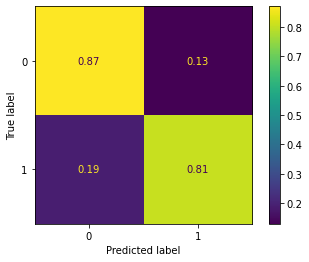

In [16]:
cross_val_evaluate(logreg_pipe0, X_train, y_train)

#### Decision Tree

In [17]:
#Decision Tree pipeline
d_tree_pipe0 = Pipeline(steps=[
    ('prep', preprocessor),
    ('d_tree0', DecisionTreeClassifier(random_state=42,
                                       max_depth=10,
                                       class_weight='balanced'))
])

In [18]:
#fit d_tree0
d_tree_pipe0.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.77928237 0.77470317 0.78007457 0.77961667 0.76692615]
Train Accuracy 0.7761205860243526


[0.75837258 0.75130822 0.76409787 0.75886432 0.74604213]
Cross-Validation Accuracy 0.7557370226142772


Training Recall: 0.7027971149142014
Test Recall: 0.67989064868531


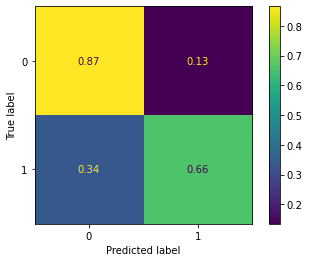

In [19]:
#cross validate and evaluate
cross_val_evaluate(d_tree_pipe0, X_train, y_train)

#### Random Forest Classifier

In [20]:
#Random Forest Pipeline
rf_pipe0 = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf0', RandomForestClassifier(max_depth=5,
                                   n_estimators=50,
                                   class_weight='balanced',
                                   random_state=42))
])

In [21]:
#fit random forest 0
rf_pipe0.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.70061819 0.7033003  0.69238569 0.67698044 0.69693203]
Train Accuracy 0.6940433304015843


[0.68524333 0.70185767 0.69750098 0.66766976 0.69187492]
Cross-Validation Accuracy 0.688829331388349


Training Recall: 0.7002138008889498
Test Recall: 0.6928224236551496


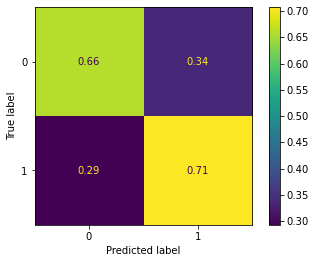

In [22]:
#cross validate / evaluate
cross_val_evaluate(rf_pipe0, X_train, y_train)

#### KNN Model

In [23]:
#KNN pipeline
knn_pipe0 = Pipeline(steps=[
    ('prep', preprocessor),
    ('knn_pipe0', KNeighborsClassifier())
])
#fit knn
knn_pipe0.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.85274589 0.85366173 0.85337215 0.85206385 0.85494211]
Train Accuracy 0.8533571427200535


[0.78584511 0.78506018 0.78660212 0.79013476 0.78660212]
Cross-Validation Accuracy 0.7868488576400579


Training Recall: 0.8013308751645006
Test Recall: 0.7250421479727291


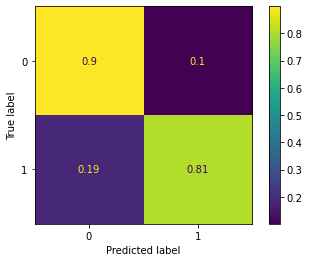

In [24]:
#evaluate KNN
cross_val_evaluate(knn_pipe0, X_train, y_train)

> *The KNN model has a longer runtime than the other models for little improvement in performance. No thank you!

And ofcourse, we have to have the XGBoost. YOU SIMPLY MUST (X D)

#### Extreme Gradient Boost

In [25]:
# XGBoost Pipeline
xgb_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('xgb_0', xgb.XGBClassifier(learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            n_estimators=100,
            seed=42))
])

In [26]:
# fit XGBoost classifer
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.77035293 0.77051647 0.77186498 0.77225747 0.77052397]
Train Accuracy 0.7711031652344775


[0.76569859 0.76439037 0.76815387 0.77024729 0.75768677]
Cross-Validation Accuracy 0.7652353764501202


Training Recall: 0.6067036916496574
Test Recall: 0.5995716512201905


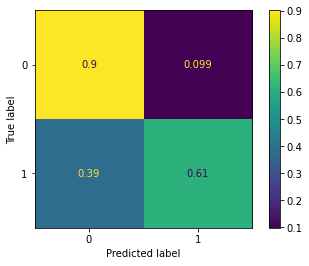

In [27]:
#Evaluate
cross_val_evaluate(xgb_pipe, X_train, y_train)

> Event the 'ol reliable XGBoost preforms worse than the baseline logistic regression model.

**Hyperparameter Tuning Logistic Regression model**

In [28]:
# classification_report(y_test, y_pred)
y_true = le.transform(y_test)
y_pred = logreg_pipe0.predict(X_test)
report = classification_report(y_pred=y_pred, y_true=y_true)

# Print table
print(report)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      6966
           1       0.78      0.75      0.77      5773

    accuracy                           0.79     12739
   macro avg       0.79      0.79      0.79     12739
weighted avg       0.79      0.79      0.79     12739



In [29]:
#parameter grid
params = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['newton-cg', 'lbfgs']}
#Perform Grid Search
grid_search_lr0 = GridSearchCV(logreg_pipe0, params, cv=5)
grid_search_lr0.fit(X_train, y_train)

#Evaluate gridsearch
print(f'Best Hyperparameters: {grid_search_lr0.best_params_}')
print(f'Best Score: {grid_search_lr0.best_score_}')

Best Hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Best Score: 0.790826219878948


**Fit and package Best model**

#### Ideal Model

In [30]:
#Best pipeline
ideal_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('log_reg_best', LogisticRegression(penalty='l2',
                                        C=1, 
                                        solver='newton-cg' ))
])

In [31]:
#fit ideal pipeline
ideal_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'region_code',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

[0.87017957 0.87073562 0.86835219 0.87018382 0.8701184 ]
Train Accuracy 0.8699139197696514


[0.79173208 0.79029304 0.80321863 0.7960225  0.78437786]
Cross-Validation Accuracy 0.7931288231030292


Training Recall: 0.808793825525506
Test Recall: 0.7180544375746509


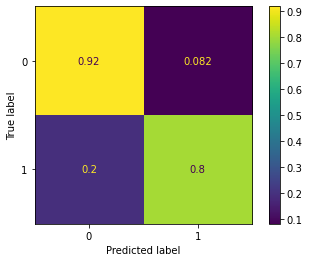

In [32]:
# cross val evaluation
cross_val_evaluate(ideal_pipe, X_train, y_train)

**Try Feature Selection**
> * Use Seleck K-Best using *chi_square* test

In [33]:
#Model with feature selector
ideal_pipe1 = Pipeline(steps=[
    ('prep', preprocessor),
    ('feat_select', SelectKBest(score_func=f_classif)),
    ('log_reg_2', LogisticRegression())
])
# ideal_pipe1.fit(X_train, y_train)

In [34]:
#Tune Hyperparameters
params = {
    'feat_select__k': [5, 10, 15],
    'log_reg_2__penalty': ['l2'],
    'log_reg_2__C': [0.01, 0.1, 1,],
    'log_reg_2__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

# Perform grid search cross-validation to find the best hyperparameters
ideal_pipe1_grdsrch = GridSearchCV(ideal_pipe1, params, cv=5)

# Fit the grid search to the training data
ideal_pipe1_grdsrch.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", ideal_pipe1_grdsrch.best_params_)
print("Best score: ", ideal_pipe1_grdsrch.best_score_)

Best hyperparameters:  {'feat_select__k': 10, 'log_reg_2__C': 0.1, 'log_reg_2__penalty': 'l2', 'log_reg_2__solver': 'sag'}
Best score:  0.7244942804465057


> Using a `sklearn`'s `SelectKBest` feature selector worsens our overall model score. This probably ar a result of the increased bias.

### Conclusion

* The Baseline **Logistic Regression** performs well on our classification metrics i.e **accuracy** and **recall**
Accuracy is a valid metric as the class imbalance is negligible as seen in the data exploration

* The **KNN model** performs similarly to the Logistic Regression. However, due to its exponentially increasing time complexity, this model has a much longer runtime
The *runtime* does not justify using this model.

* Both **Decision Trees** and their ensemble counterpart, **Random Forest** performed worse than the baseline model.

* After tuning the Logistic Regression model, as it preforms best, we obtain the best parameters.

* Using a feature selector proved detrimental to the modelling process.

> `BEST MODEL:` **logistic regression(tuned)**